# Interpretability of autoencoder latent space for passengers demand-sensitive planning on high-speed railways (IWANN 2023)


In [1]:
import datetime
import pandas as pd
import nltk
import numpy as np
import os
import random

from feature_engine.creation import CyclicalFeatures
from nltk.corpus import wordnet
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
from typing import Tuple

In [2]:
# Download wordnet if not already downloaded
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/uclm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from src.robin.supply.entities import Supply

path_config_supply = '../configs/test_case/supply_data.yml'

supply = Supply.from_yaml(path_config_supply)

# Get set of corridors
corridors = []
for service in supply.services:
    if service.line.corridor not in corridors:
        corridors.append(service.line.corridor)

# Get set of paths
paths = []
for corridor in corridors:
    for path in corridor.paths:
        if path not in paths:
            paths.append(path)

# Parse paths of Station objects to paths of station mame
paths = [[station.name.replace("-", " ").split(" ")[0].lower() for station in path] for path in paths]
print(paths)

[['madrid', 'guadalajara', 'calatayud', 'zaragoza', 'lleida', 'tarragona', 'barcelona', 'girona', 'figueres']]


In [4]:
def get_word_syn(word: str) -> str:
    """
    Get a random synonym of a word

    Args:
        word (str): Word to get the synonym from

    Returns:
        str: Synonym of the word
    """
    word_synset = wordnet.synsets(word)
    if len(word_synset) > 0:
        station_synset = word_synset[0]
        station_lemmas = station_synset.lemmas()
        if len(station_lemmas) > 0:
            word_lemma = random.choice(station_lemmas)
            return word_lemma.name().lower()

    return word

def get_random_pair(paths: list[list]) -> Tuple[str, str]:
    """
    Get a random pair of stations from a path

    Args:
        paths (list[list]): List of stations

    Returns:
        Tuple[str, str]: Tuple with the origin and destination stations
    """
    random_path = random.choice(paths)  # Choose a random path

    origin_index = random.randint(0, len(random_path) - 2)  # Choose a random origin station
    destination_index = random.randint(origin_index + 1, len(random_path) - 1)  # Choose a random destination station

    origin_station = random_path[origin_index]
    destination_station = random_path[destination_index]
    return origin_station, destination_station

In [5]:
stations_csv_path = f'../data/renfe/renfe_stations.csv'

def get_renfe_station_id(adif_id: str, stations_df: pd.DataFrame) -> str:
    """
    Returns the Station name given the Adif station id.

    Args:
        adif_id (str): Adif station id.
        stations_df (pd.DataFrame): Dataframe with the stations' information.

    Returns:
        str: Station name.
    """
    station_name = stations_df[stations_df['stop_id'] == adif_id]['stop_name'].values[0]
    station_name = station_name.replace("-", " ").split(" ")[0].lower()
    return station_name

stations_df = pd.read_csv(stations_csv_path, dtype={'stop_id': str, 'renfe_id': str})

In [6]:
n_passengers = 10000

pairs = []
for _ in range(n_passengers):
    pairs.append(get_random_pair(paths))

df = pd.DataFrame(pairs, columns=['origin', 'destination'])

user_patterns = ("business", "student", "tourist")

df['user_pattern'] = [random.choice(user_patterns) for _ in range(n_passengers)]

random_timedelta = lambda: datetime.timedelta(days=random.randint(0, 365*10), hours=random.randint(0, 24), minutes=random.randint(0, 60))
df['arrival_date'] = [datetime.datetime(2021, 1, 1) + random_timedelta() for _ in range(n_passengers)]
print(df.head())

        origin destination user_pattern        arrival_date
0  guadalajara   tarragona      tourist 2022-02-11 20:17:00
1       madrid      lleida      tourist 2028-05-02 10:47:00
2    barcelona    figueres     business 2024-03-01 13:14:00
3       madrid   barcelona     business 2030-04-27 02:18:00
4       madrid      girona     business 2026-06-16 11:44:00
       year     month_sin     month_cos   day_sin   day_cos  hour_sin  \
0  0.111111  8.660254e-01  5.000000e-01  0.790776 -0.612106 -0.730836   
1  0.777778  5.000000e-01 -8.660254e-01  0.394356  0.918958  0.398401   
2  0.333333  1.000000e+00  6.123234e-17  0.201299  0.979530 -0.398401   
3  1.000000  8.660254e-01 -5.000000e-01 -0.724793  0.688967  0.519584   
4  0.555556  1.224647e-16 -1.000000e+00 -0.101168 -0.994869  0.136167   

   hour_cos  minute_sin  minute_cos  
0  0.682553    0.971430   -0.237327  
1 -0.917211   -0.957422    0.288692  
2 -0.917211    0.996812    0.079786  
3  0.854419    0.940700   -0.339239  
4 -0.990686

In [28]:
class AutoencoderEmbedding:
    def __init__(self, df: pd.DataFrame, embedding_dim: int = 50):
        self.df = df
        self.df_embedding = pd.DataFrame()
        self.embedding_dim = embedding_dim
        self.embedding_dict = self._get_embedding_dict()
        self.scaler = MinMaxScaler()
        self.cyclical = CyclicalFeatures(variables=['month', 'day', 'hour', 'minute'], drop_original=True)
        self.df_time = self._get_time_embdding_df(df)
        self.input_arrays = self._get_input_arrays()

    def _get_time_embdding_df(self, df: pd.DataFrame) -> pd.DataFrame:
        df_time = pd.DataFrame()
        df_time['year'] = df['arrival_date'].apply(lambda x: x.year)
        df_time['month'] = df['arrival_date'].apply(lambda x: x.month)
        df_time['day'] = df['arrival_date'].apply(lambda x: x.day)
        df_time['hour'] = df['arrival_date'].apply(lambda x: x.hour)
        df_time['minute'] = df['arrival_date'].apply(lambda x: x.minute)
        df_time['year'] = self.scaler.fit_transform(df_time['year'].to_numpy().reshape(-1, 1))
        df_time = self.cyclical.fit_transform(df_time)
        return df_time

    def _get_embedding_dict(self):
        # Get bag of words
        words_set = set(self.df[['origin', 'destination', 'user_pattern', ]].values.flatten())
        word_index = {word: index for index, word in enumerate(words_set)}

        embeddings_index = {}
        f = open(os.path.join('../data/pretrained/glove6B/glove.6B.50d.txt'))

        # Read GloVe embeddings
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype=np.float32)
            embeddings_index[word] = coefs
        f.close()

        # Create embedding matrix
        embedding_matrix = np.zeros((len(word_index) + 1, self.embedding_dim))
        embedding_dict = {}
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                embedding_dict[word] = embedding_vector

        return embedding_dict

    def _get_input_arrays(self):
        self.df_embedding['origin'] = self.df['origin'].apply(lambda x: self.embedding_dict.get(x))
        self.df_embedding['destination'] = self.df['destination'].apply(lambda x: self.embedding_dict.get(x))
        self.df_embedding['user_pattern'] = self.df['user_pattern'].apply(lambda x: self.embedding_dict.get(x))
        self.df_embedding['scaled_date'] = self.df_time.values.tolist()
        self.df_embedding['scaled_date'] = self.df_embedding['scaled_date'].apply(lambda x: np.asarray(x + [0.0] * (self.embedding_dim - len(x)), dtype=np.float32))
        self.df_embedding = self.df_embedding[['origin', 'destination', 'user_pattern', 'scaled_date']]
        input_data = self.df_embedding[['origin', 'destination', 'user_pattern', 'scaled_date']].values.tolist()
        return np.array([np.asarray(row, dtype=np.float32) for row in input_data])

In [34]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

train_embedding = AutoencoderEmbedding(df_train)
test_embedding = AutoencoderEmbedding(df_test)

print("Test data autoencoder input shape: ", test_embedding.input_arrays.shape)
print("First test data instance: ", test_embedding.df.iloc[0])
print("First test data instance embedded: ", test_embedding.input_arrays[0])

Train data shape:  (7000, 4)
Test data shape:  (3000, 4)
Test data autoencoder input shape:  (3000, 4, 50)
First test data instance:  origin                     zaragoza
destination                  lleida
user_pattern                tourist
arrival_date    2027-09-01 14:26:00
Name: 6252, dtype: object
First test data instance embedded:  [[ 1.0642000e+00  8.9938998e-02 -2.8715000e-01  8.2471001e-01
   3.1062999e-01 -1.4798000e+00  1.2028000e-01  7.4489999e-01
  -1.2919000e+00  3.9737001e-01  4.7150001e-01 -5.3482997e-01
  -4.8049000e-01 -1.2998000e+00  3.2826000e-01 -1.3085001e+00
  -6.7916000e-01 -2.0625000e-01 -7.2320002e-01  4.1637999e-01
  -1.2895000e+00 -6.9963002e-01 -2.3631001e-01  7.0174998e-01
  -6.1497998e-01  2.0193000e-01  1.3290000e+00  2.5294000e-01
  -9.3714997e-02 -1.6535001e-01  9.9605000e-01  1.2007000e+00
  -2.6729000e-01 -4.2034999e-01 -1.5881000e-01  6.3906002e-01
  -7.3977000e-01  1.3119000e+00  6.1136001e-01 -5.9197003e-01
   1.3032000e+00  1.6094001e-01 -2.76860

## Embedding Model

## Autoencoder model

In [10]:
import tensorflow as tf
from keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed
from keras.models import Model

input_shape = (4, EMBEDDING_DIM)
output_shape = (4, EMBEDDING_DIM)

latent_dim = 4

inputs = Input(shape=input_shape)

encoder = GRU(64, return_sequences=True)(inputs)
encoder = GRU(32)(encoder)

dense1 = Dense(4)(encoder)
decoder_inputs = Input(shape=(latent_dim,))
decoder = RepeatVector(input_shape[0])(decoder_inputs)
decoder = GRU(32, return_sequences=True)(decoder)
decoder = GRU(64, return_sequences=True)(decoder)
decoder_outputs = TimeDistributed(Dense(output_shape[1]))(decoder)

encoder_model = Model(inputs, dense1)
decoder_model = Model(decoder_inputs, decoder_outputs)

model = Model(inputs, decoder_model(dense1))

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

2023-05-16 12:23:33.073371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 12:23:40.503419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 50)]           0         
                                                                 
 gru (GRU)                   (None, 4, 64)             22272     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
 model_1 (Functional)        (None, 4, 50)             25714     
                                                                 
Total params: 57,526
Trainable params: 57,526
Non-trainable params: 0
_________________________________________________________________


In [20]:
import tensorflow as tf
from keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed
from keras.models import Model
from keras import backend as K

beta = 5

input_shape = (4, EMBEDDING_DIM)
output_shape = (4, EMBEDDING_DIM)
latent_dim = 4

inputs = Input(shape=input_shape)

# Encoder
encoder = GRU(64, return_sequences=True)(inputs)
encoder = GRU(32)(encoder)

# Latent layer
z_mean = Dense(latent_dim)(encoder)
z_log_var = Dense(latent_dim)(encoder)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
decoder = RepeatVector(input_shape[0])(decoder_inputs)
decoder = GRU(32, return_sequences=True)(decoder)
decoder = GRU(64, return_sequences=True)(decoder)
decoder_outputs = TimeDistributed(Dense(output_shape[1]))(decoder)

# Use z_mean as encoder output to obtain a disentangled latent representation
encoder_model = Model(inputs, z_mean)

decoder_model = Model(decoder_inputs, decoder_outputs)

# VAE model
vae_outputs = decoder_model(z)
model = Model(inputs, vae_outputs)

# Loss function
reconstruction_loss = tf.keras.losses.mean_squared_error(K.flatten(inputs), K.flatten(vae_outputs))
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
model.add_loss(vae_loss)

model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4, 50)]      0           []                               
                                                                                                  
 gru_4 (GRU)                    (None, 4, 64)        22272       ['input_3[0][0]']                
                                                                                                  
 gru_5 (GRU)                    (None, 32)           9408        ['gru_4[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 4)            132         ['gru_5[0][0]']                  
                                                                                            

In [22]:
import tensorflow as tf
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Conv1DTranspose
from keras.models import Model
from keras import backend as K

beta = 5
SEQUENCE_LENGTH = 4

input_shape = (SEQUENCE_LENGTH, EMBEDDING_DIM)
latent_dim = 4

inputs = Input(shape=input_shape)

# Encoder
encoder = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
encoder = Conv1D(32, kernel_size=3, activation='relu', padding='same')(encoder)
encoder = GlobalMaxPooling1D()(encoder)

# Latent space
z_mean = Dense(latent_dim)(encoder)
z_log_var = Dense(latent_dim)(encoder)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder = Dense(32 * SEQUENCE_LENGTH, activation='relu')(z)
decoder = tf.keras.layers.Reshape((SEQUENCE_LENGTH, 32))(decoder)
decoder = Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same')(decoder)
decoder_outputs = Conv1DTranspose(EMBEDDING_DIM, kernel_size=3, padding='same')(decoder)

encoder_model = Model(inputs, z_mean)
decoder_model = Model(z, decoder_outputs)

vae_outputs = decoder_model(z)
model = Model(inputs, vae_outputs)

# Loss function
reconstruction_loss = tf.keras.losses.mean_squared_error(K.flatten(inputs), K.flatten(vae_outputs))
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
model.add_loss(vae_loss)

model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4, 50)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4, 64)        9664        ['input_5[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4, 32)        6176        ['conv1d[0][0]']                 
                                                                                                  
 global_max_pooling1d (GlobalMa  (None, 32)          0           ['conv1d_1[0][0]']               
 xPooling1D)                                                                                

In [23]:
history = model.fit(input_vectors, input_vectors, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
313/313 [==============================] - 2s 2ms/step - loss: 0.4830 - mean_squared_error: 0.1952
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3652 - mean_squared_error: 0.1815
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3627 - mean_squared_error: 0.1811
Epoch 4/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3620 - mean_squared_error: 0.1810
Epoch 5/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3617 - mean_squared_error: 0.1808
Epoch 6/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3616 - mean_squared_error: 0.1808
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3615 - mean_squared_error: 0.1807
Epoch 8/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3614 - mean_squared_error: 0.1807
Epoch 9/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3611 - mean_squared_error: 0.1806
Epoch 10/1

## Plot history

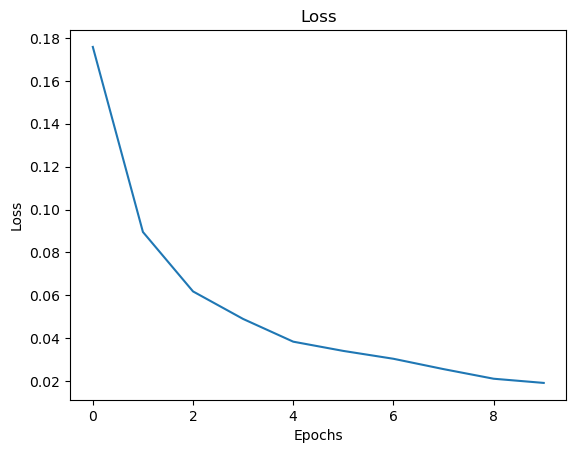

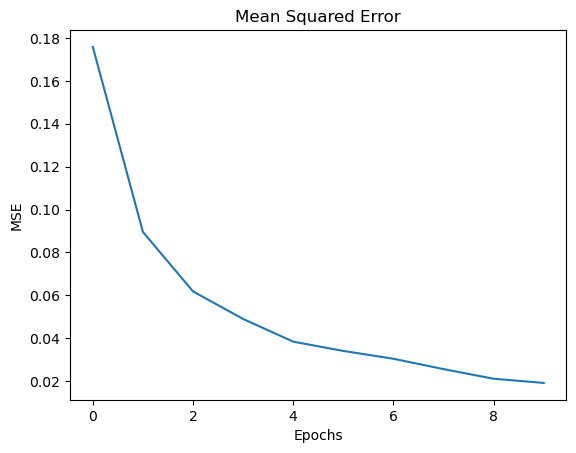

In [12]:
# Plot history loss and mse

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['mean_squared_error'], label='mse')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Make predictions

In [13]:
def find_closest_embeddings(embedding, embedding_dict):
    return sorted(embedding_dict.keys(), key=lambda word: spatial.distance.euclidean(embedding_dict[word], embedding))[0]

In [19]:
random_index = np.random.randint(0, len(input_vectors))
random_vector = input_vectors[random_index]

print("Input - Random passenger data: ")
print(df.iloc[random_index])

latent_passenger = encoder_model.predict(np.array([random_vector]))[0]
print("Passenger latent representation: ", latent_passenger)
print()

prediction = model.predict(np.array([random_vector]))[0]

print("Output - Passenger reconstruction: ")
decoded_prediction = [find_closest_embeddings(word_vector, embedding_dict) for word_vector in prediction[:3]]
print(decoded_prediction)

print("Time prediction: ", prediction[-1])
predicted_year = scaler.inverse_transform(np.array([prediction[-1][:1]]))
print(int(predicted_year[0][0]))

Input - Random passenger data: 
origin                  guadalajara
destination               calatayud
user_pattern                tourist
arrival_date    2027-05-08 06:13:00
Name: 7656, dtype: object
1/1 [==============================] - 0s 17ms/step
Passenger latent representation:  [-6.1458554  3.8044672 -1.9451089  1.5636346]

1/1 [==============================] - 0s 18ms/step
Output - Passenger reconstruction: 
['guadalajara', 'calatayud', 'tourist']
Time prediction:  [ 0.48759338 -0.1452848  -0.1781346  -0.00495388 -0.36946034 -0.1675351
  0.00949998  0.04923538  0.15281405 -0.02114248 -0.01651346  0.0246156
 -0.05150862  0.02118156  0.03440116 -0.02508917  0.02160763 -0.02805975
 -0.03147184 -0.00565742 -0.07573982  0.03409792 -0.00905403  0.00550454
 -0.0231083  -0.06281231  0.05571634  0.02883877 -0.03558009 -0.01564036
  0.01500612 -0.0157849  -0.04870672 -0.0508803  -0.02118523 -0.02023008
  0.02356025 -0.01290327 -0.01915103  0.03371991  0.0238549   0.02204522
  0.044239

Mes y día como palabra, hora pensar idea para representar (ángulo?)

## Estudio de la correlación entre factores latentes y la entrada del autoencoder